In [1]:
import sys
import os

sys.path.append(os.path.join('..'))

In [2]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [3]:
from src.utils.seed import set_random_seed

# Set the random seed for deterministic operations.
SEED = 42
set_random_seed(SEED)

https://github.com/LMissher/STGNN/blob/main/model.py

In [4]:
import torch

# Set the device for training and querying the model.
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The selected device is: "{DEVICE}"')

The selected device is: "cuda"


Link to download the datasets: https://graphmining.ai/temporal_datasets/

DEPENDENCY Pytables

# 1 Metr-LA Dataset

ORIGINAL PAPER: https://arxiv.org/pdf/1707.01926.pdf

***Metr-LA:*** This traffic dataset contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish et al., 2014). We select $207$ sensors andcollect 4 months of data ranging from Mar $1^{st}$ $2012$ to Jun $30^{th}$ $2012$ for the experiment.

In both of those datasets, we aggregate traffic speed readings into 5 minutes windows.

The total number of observed traffic data points is $6,519,002$.

In [5]:
# Set the base data directory.
BASE_DATA_DIR = os.path.join('..', 'data', 'pems-bay')

# Splitting the dataset

In [6]:
import numpy as np
from src.data.data_extraction import get_node_values_dataframe

# Get the dataframe containing the node values at different timestamps for Pems Bay.
node_values_df = get_node_values_dataframe(
    os.path.join(BASE_DATA_DIR, 'pems-bay.h5'), turn_in_kmph=False)

node_values = np.expand_dims(node_values_df.to_numpy(), axis=-1)

The adjacency matrix is built by exploiting the pairwise road network distances
between sensors through a thresholded Gaussian kernel (Shuman et al., 2013).

$$
W_{ij} = \begin{cases}
\text{exp} \left ( - \frac{\text{dist}(v_i - v_j)^2}{\sigma^2} \right ) & \text{if} \ \text{dist}(v_i - v_j) \leq k \\
0 & \text{otherwise}\\
\end{cases}
$$

where $W_{ij}$ represents the edge weight between sensor $v_i$ and sensor $v_j$, $\text{dist}(v_i - v_j)$ denotes the road network distance from sensor $v_i$ to sensor $v_j$ . $\sigma$ is the standard deviation of distances and $k$ ($0.1$ in the original paper) is the threshold.


In [7]:
import pickle

with open(os.path.join(BASE_DATA_DIR, 'adj_mx_pems_bay.pkl'), 'rb') as f:
    adj_matrix_structure = pickle.load(f, encoding='latin1')

In [8]:
header, node_id_positions, adj = adj_matrix_structure

In [9]:
assert all(header == node_values_df.columns.values), \
    'The columns of the node_values_df are not ordered in the same way as the adj_matrix '

In [10]:
print(node_values.shape)

(52116, 325, 1)


In [11]:
print(adj.shape)

(325, 325)


In [12]:
from src.data.dataset_builder import train_test_val_split
x_train, x_val, x_test = train_test_val_split(node_values, test_size=.2,
                                              val_size=.1)

In [13]:
print(x_train.shape, x_val.shape, x_test.shape)

(38356, 325, 1) (3336, 325, 1) (10424, 325, 1)


In [14]:
import pandas as pd
import numpy as np

t, n, f = x_train.shape
out_arr = np.column_stack((np.repeat(np.arange(t),n), x_train.reshape(t*n,-1)))
out_df = pd.DataFrame(out_arr, columns=['timestep', 'speed'])
out_df.head()

timestep  speed
0       0.0   71.4
1       0.0   67.8
2       0.0   70.5
3       0.0   67.4
4       0.0   68.8

In [15]:
out_df.speed.describe()

count    1.246570e+07
mean     6.271380e+01
std      9.482068e+00
min      0.000000e+00
25%      6.220000e+01
50%      6.530000e+01
75%      6.750000e+01
max      8.510000e+01
Name: speed, dtype: float64

In [16]:
#out_df['time of day'].describe()

<AxesSubplot: title={'center': 'Distribution of the speed feature'}, ylabel='Frequency'>

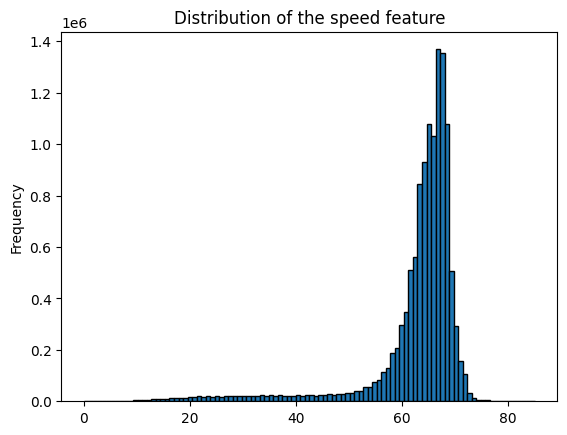

In [17]:
out_df.speed.plot(kind='hist', edgecolor='black', bins=100,
                  title='Distribution of the speed feature')

In [18]:
import torch
from sklearn.preprocessing import QuantileTransformer

class Scaler():
    def __init__(self, x: torch.FloatTensor) -> None:
        with torch.no_grad():
            x = x.clone()
            '''self.quantile_transformer_0 = QuantileTransformer(
                n_quantiles=500, output_distribution="normal", random_state=SEED
            )
            feature_shape = x[..., 0].shape
            raveled_feature = x[..., 0].cpu().numpy().reshape(-1, 1)
            self.quantile_transformer_0.fit(raveled_feature)
            quantile_transformed = self.quantile_transformer_0.transform(raveled_feature)
            x[..., 0] = torch.tensor(
                quantile_transformed.reshape(feature_shape),
                device=x.device)'''
            # End for feature 0
            #self.max = torch.stack([torch.max(x[..., i]) for i in range(x.shape[-1])])
            #self.min = torch.stack([torch.min(x[..., i]) for i in range(x.shape[-1])])
            self.mean = torch.mean(x, dim=(-3, -2))
            self.std = torch.std(x, dim=(-3, -2))

    def scale(self, x: torch.FloatTensor):
        x = x.clone()
        '''feature_shape = x[..., 0].shape
        raveled_feature = x[..., 0].cpu().numpy().reshape(-1, 1)
        quantile_transformed = self.quantile_transformer_0.transform(raveled_feature)
        x[..., 0] = torch.tensor(
            quantile_transformed.reshape(feature_shape),
            device=x.device)
        n_features = x.shape[-1]
        mean = self.mean.to(x.device)
        std = self.std.to(x.device)
        x = (x - mean[:n_features]) / std[:n_features]'''
        mean = self.mean.to(x.device)
        std = self.std.to(x.device)
        x = (x - mean) / std
        return x

    def un_scale(self, x: torch.FloatTensor):
        x = x.clone()
        '''n_features = x.shape[-1]
        mean = self.mean.to(x.device)
        std = self.std.to(x.device)
        x = x * std[:n_features] + mean[:n_features]
        feature_shape = x[..., 0].shape
        raveled_feature = x[..., 0].cpu().numpy().reshape(-1, 1)
        quantile_transformed = self.quantile_transformer_0.inverse_transform(raveled_feature)
        x[..., 0] = torch.tensor(
            quantile_transformed.reshape(feature_shape),
            device=x.device)'''
        mean = self.mean.to(x.device)
        std = self.std.to(x.device)
        x = x * std + mean
        return x

scaler = Scaler(torch.tensor(x_train, dtype=torch.float32))

In [19]:
print(scaler.mean)
print(scaler.std)

tensor([62.7138])
tensor([9.4821])


In [20]:
import pandas as pd
import numpy as np

scaled_x_train = scaler.scale(torch.tensor(x_train, dtype=torch.float32))

t, n, f = scaled_x_train.shape
out_arr = np.column_stack((np.repeat(np.arange(t),n), scaled_x_train.reshape(t*n,-1)))
out_df = pd.DataFrame(out_arr, columns=['timestep', 'speed'])
out_df.head()

timestep     speed
0       0.0  0.916066
1       0.0  0.536402
2       0.0  0.821150
3       0.0  0.494217
4       0.0  0.641864

In [21]:
out_df.speed.describe()

count    1.246570e+07
mean    -4.798104e-07
std      1.000000e+00
min     -6.613938e+00
25%     -5.418666e-02
50%      2.727465e-01
75%      5.047631e-01
max      2.360898e+00
Name: speed, dtype: float64

<AxesSubplot: title={'center': 'Distribution of the speed feature'}, ylabel='Frequency'>

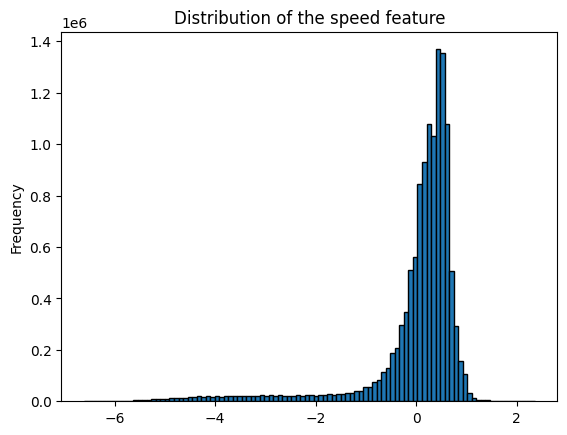

In [22]:
out_df.speed.plot(kind='hist', edgecolor='black', bins=100,
                  title='Distribution of the speed feature')

In [23]:
T = 12

In [24]:
def window_stack(a, stepsize=T):
    n_instances, n_nodes, n_features = a.shape
    resulting_batches = n_instances // stepsize
    return np.stack(
        [a[i * stepsize : i * stepsize + stepsize] for i in range(resulting_batches)] )
#slided_x_train = sliding_window_view(x_train, 12, axis=0)
#x_train, y_train = np.array([x for x in x_train[::T]]), np.array([x for x in x_train[T::T]])
x_train = window_stack(x_train)
x_val = window_stack(x_val)
x_test = window_stack(x_test)

In [25]:
print(x_train.shape)

(3196, 12, 325, 1)


In [26]:
x_train_og = x_train.copy()

In [27]:
x_train, y_train = np.array([x for x in x_train[::2]]), np.array([x for x in x_train[1::2]])
x_train = x_train[:y_train.shape[0]]
x_val, y_val = np.array([x for x in x_train[::2]]), np.array([x for x in x_train[1::2]])
x_val = x_val[:y_val.shape[0]]
x_test, y_test = np.array([x for x in x_test[::2]]), np.array([x for x in x_test[1::2]])
x_test = x_test[:y_test.shape[0]]

In [28]:
'''y_train = y_train[..., :1]
y_val = y_val[..., :1]
y_test = y_test[..., :1]'''

'y_train = y_train[..., :1]\ny_val = y_val[..., :1]\ny_test = y_test[..., :1]'

In [29]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train.shape, y_train.shape)

(1598, 12, 325, 1) (1598, 12, 325, 1)
(434, 12, 325, 1) (434, 12, 325, 1)
(1598, 12, 325, 1) (1598, 12, 325, 1)


In [30]:
torch.std_mean(torch.tensor(adj))

(tensor(0.1097), tensor(0.0157))

In [31]:
import torch
from torch import nn
import numpy as np

import math
import torch
from torch import nn

class S_GNN(nn.Module):
    """
    Apply a Spatial GNN module to capture the spatial relations of
    an instance of a graph of a sequence.
    """
    def __init__(self, n_features: int, A_hat: torch.FloatTensor) -> None:
        super().__init__()
        # Module to obtain the latent representation of the input.
        self.latent_encoder = nn.Sequential(
            nn.Linear(n_features, n_features, bias=False),
            nn.Linear(n_features, n_features // 2, bias=False)
        )

        # Linear layer to model the spatial feature extraction.
        self.linear = nn.Linear(n_features, n_features, bias=False)

        # Set the refined adjacency matrix.
        self.A_hat = A_hat

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        # Get the latent representation of the input.
        p = self.latent_encoder(x)

        # Apply the score function.
        S = p @ p.transpose(-1, -2)
        # Stabilize score function to avoid softmax overflowing.
        S_stabilized = S - torch.max(S, dim=-1, keepdim=True).values

        # Get the pair-wise relation between any road node.
        R = torch.softmax(S_stabilized, -1)
        #R = torch.softmax(S, -1)

        # Get the sparsified relation matrix.
        A_hat = self.A_hat.expand_as(R)
        R_hat = R * (A_hat > 0).float() 
        R_hat += torch.eye(R_hat.shape[-2], R_hat.shape[-1], device=x.device)

        # Get refined degree matrix from the sparsified relation matrix.
        D_hat = R_hat.sum(-1) ** -.5
        # D_hat[torch.isinf(D_hat)] = 0.
        D_hat = torch.diag_embed(D_hat)

        # Apply the modified GCN operation.
        A = D_hat @ R_hat @ D_hat
        return torch.relu(self.linear(A @ x))

class GRU(nn.Module):
    """
    Apply a Gated Recurrent Unit (GRU) RNN to a hidden representation
    of an instance of a graph of a sequence.
    """
    def __init__(self, n_input_features: int, n_hidden_features: int) -> None:
        super().__init__()
        # Update gate layers.
        self.z_x_linear = nn.Linear(n_input_features, n_hidden_features, bias=False)
        self.z_h_linear = nn.Linear(n_hidden_features, n_hidden_features, bias=False)

        # Reset gate layers.
        self.r_x_linear = nn.Linear(n_input_features, n_hidden_features, bias=False)
        self.r_h_linear = nn.Linear(n_hidden_features, n_hidden_features, bias=False)

        # State gate layers.
        self.h_x_linear = nn.Linear(n_input_features, n_hidden_features, bias=False)
        self.h_h_linear = nn.Linear(n_hidden_features, n_hidden_features, bias=False)

    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor
                ) -> torch.FloatTensor:
        # Update Gate.
        z_x = self.z_x_linear(x)
        z_h = self.z_h_linear(h)
        z_t = torch.sigmoid(z_x + z_h)

        # Reset Gate.
        r_x = self.r_x_linear(x)
        r_h = self.r_h_linear(h)
        r_t = torch.sigmoid(r_x + r_h)

        # State gate.
        h_x = self.h_x_linear(x)
        h_h = self.h_h_linear(h)
        h_t = torch.tanh(h_x + r_t * h_h)

        # Get GRU output.
        return (1 - z_t) * h_t + z_t * h
    
'''class GRU(nn.Module):
    def __init__(self, outfea, inf):
        super(GRU, self).__init__()
        self.ff = nn.Linear(2*outfea, 2*outfea)
        self.zff = nn.Linear(2*outfea, outfea)
        self.outfea = outfea

    def forward(self, x, xh):
        r, u = torch.split(torch.sigmoid(self.ff(torch.cat([x, xh], -1))), self.outfea, -1)
        z = torch.tanh(self.zff(torch.cat([x, r*xh], -1)))
        x = u * z + (1-u) * xh
        return x'''

class Transformer(nn.Module):
    """
    Apply the multi-head attention mechanism to the hidden representations
    of the graph sequences for a global understanding of the time
    relation.
    """
    def __init__(self, n_features: int, n_timesteps: int, n_attention_heads: int) -> None:
        super().__init__()
        # Set the number of attention heads.
        self.n_attention_heads = n_attention_heads

        # Linear layers to model the queries, keys and values.
        self.queries_linear = nn.Linear(n_features, n_features, bias=False)
        self.keys_linear = nn.Linear(n_features, n_features, bias=False)
        self.values_linear = nn.Linear(n_features, n_features, bias=False)

        # Normalization layers.
        self.normalization = nn.BatchNorm2d(n_timesteps) #nn.LayerNorm(n_features)
        self.normalization_out = nn.BatchNorm2d(n_timesteps) #nn.LayerNorm(n_features)

        # Multi-layer feed forward module.
        self.feed_forward = nn.Sequential(
            nn.Linear(n_features, n_features, bias=False),
            nn.ReLU(),
            nn.Linear(n_features, n_features, bias=False)
        )

    def forward(self, x):
        # Get queries, keys and values.
        Q = self.queries_linear(x)
        K = self.keys_linear(x)
        V = self.values_linear(x)

        # Split Q, K and V features according to the attention head number.
        # Concatenate the attention heads row-wise.
        Q_h = torch.cat(torch.split(Q, self.n_attention_heads, -1), 0)
        K_h = torch.cat(torch.split(K, self.n_attention_heads, -1), 0)
        V_h = torch.cat(torch.split(V, self.n_attention_heads, -1), 0)

        # Reshape the matrices in order to apply the operations node-wise.
        permutation = [0, 2, 1, 3]
        Q_h = Q_h.permute(*permutation)
        K_h = K_h.permute(*permutation)
        V_h = V_h.permute(*permutation)

        # Apply the multi-head attention mechanism.
        H = Q_h @ K_h.transpose(-2, -1) / (self.n_attention_heads ** .5)
        H = torch.softmax(H, -1)
        H = H @ V_h

        # Split the result according to the batch size and re-concatenate.
        out = torch.cat(torch.split(H, x.shape[0], 0), -1)
        # Reshape the matrix to the original form.
        out = out.permute(*permutation)

        # Apply residual connection and batch normalization.
        out += x
        #out = out.permute(0, 3, 1, 2)
        norm = self.normalization(out)
        #norm = norm.permute(0, 2, 3, 1)

        # Apply feed forward module.
        out = self.feed_forward(norm)

        # Apply residual connection and batch normalization.
        out += norm
        #out = out.permute(0, 3, 1, 2)
        out = self.normalization_out(out)
        #out = out.permute(0, 2, 3, 1)
        return out

class PositionalEncoder(nn.Module):
    def __init__(self, n_features: int, n_timesteps: int) -> None:
        super().__init__()
        # Initialize the positional encoder.
        positional_encoder = torch.zeros(n_timesteps, n_features)

        # Get the positions with respect to the timeseries.
        positions = torch.arange(n_timesteps).unsqueeze(1)

        # Get the divisor term for the positional encoding.
        divisor = torch.exp(torch.arange(0, n_features, 2) * 
                            (math.log(10_000.) / n_features))

        # Compute the positional encodings.
        positional_encoder[:, 0::2] = torch.sin(positions * divisor)
        positional_encoder[:, 1::2] = torch.cos(positions * divisor)

        # Reshape to consider batch and feature dimensions.
        positional_encoder = positional_encoder.unsqueeze(0).unsqueeze(2)

        # Register as a non-parameter.
        self.register_buffer('pe', positional_encoder)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return x + torch.autograd.Variable(self.pe, requires_grad=False)


class SpatialTemporalGNN(nn.Module):
    def __init__(self, n_features: int, n_timesteps: int, A: np.ndarray,
                 device: str, n_attention_heads: int = 4,
                 n_hidden_features: int = 64) -> None:
        super().__init__()
        # Set the number of hidden features.
        self.n_hidden_features = n_hidden_features

        # Get the refined adjacency matrix.
        A = torch.tensor(A, dtype=torch.float32,
                         requires_grad=False, device=device)
        A_hat = A + torch.eye(A.shape[0], A.shape[1], device=device)

        self.encoder = nn.Linear(n_features, n_hidden_features, bias=False)

        # Set the list of S-GNN modules.
        self.s_gnns = nn.ModuleList(
            [S_GNN(n_hidden_features, A_hat) for _ in range(n_timesteps)])

        # Set the list of hidden S-GNN modules.
        self.hidden_s_gnns = nn.ModuleList(
            [S_GNN(n_hidden_features, A_hat) for _ in range(n_timesteps - 1)])

        # Set the list of GRU modules.
        self.grus = nn.ModuleList(
            [GRU(n_hidden_features, n_hidden_features) for _ in range(n_timesteps)])

        # Set the positional encoder module.
        self.positional_encoder = PositionalEncoder(n_hidden_features,
                                                    n_timesteps)
        
        # Set the multi head attention module.
        self.transformer = Transformer(n_hidden_features, n_timesteps, n_attention_heads)

        #self.timeseries_feed_forward = nn.Sequential(
        #    nn.Linear(len_timeseries, len_timeseries),
        #    nn.ReLU(),
        #    nn.Linear(len_timeseries, len_timeseries) # len_timeseries_out
        #)

        # Set the multi-layer prediction head.
        self.prediction_head = nn.Sequential(
            nn.Linear(n_hidden_features, n_hidden_features, bias=False),
            nn.ReLU(),
            nn.Linear(n_hidden_features, n_features, bias=False)
        )

        # Push the model to the selected device.
        self.to(device)

    def forward(self, x: torch.FloatTensor):
        # Get the input dimensions.
        batch_size, len_timeseries, n_nodes, _ = x.shape

        # Set the base hidden state for the first GRU module.
        base_hidden_state = torch.zeros(
            [batch_size, n_nodes, self.n_hidden_features],
            dtype=torch.float32, device=x.device)

        # Set the output list of the GRU modules results.
        
        x = self.encoder(x)
        
        outs = []

        for i in range(len_timeseries):
            # Get the S_GNN output state at the given timestamp.
            out_state = self.s_gnns[i](x[:,i])
            # Get the hidden state at the previous timestamp.
            if i > 0:
                hidden_state = self.hidden_s_gnns[i - 1](hidden_state)
            else:
                hidden_state = base_hidden_state
            # Get the GRU hidden state output at the given timestamp.
            hidden_state = self.grus[i](out_state, hidden_state)
            outs.append(hidden_state)

        # Stack the GRU modules results for each timestamp.
        out = torch.stack(outs, 1)

        # Get positional encoding and combine it to the result.
        out = self.positional_encoder(out)

        # Get the transformer layer results.
        out = self.transformer(out)

        # Reshape to handle the number of output timeseries.
        # out = out.permute(0, 2, 3, 1)

        # Predict the results.
        out = self.prediction_head(out)
        return out


In [32]:
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.autograd import Variable
import math
device = 'cuda'


class Transform(nn.Module):
    def __init__(self, outfea, d):
        super(Transform, self).__init__()
        self.qff = nn.Linear(outfea, outfea)
        self.kff = nn.Linear(outfea, outfea)
        self.vff = nn.Linear(outfea, outfea)

        self.ln = nn.LayerNorm(outfea)
        self.lnff = nn.LayerNorm(outfea)

        self.ff = nn.Sequential(
            nn.Linear(outfea, outfea),
            nn.ReLU(),
            nn.Linear(outfea, outfea)
        )

        self.d = d

    def forward(self, x):
        query = self.qff(x)
        key = self.kff(x)
        value = self.vff(x)

        query = torch.cat(torch.split(query, self.d, -1), 0).permute(0,2,1,3)
        key = torch.cat(torch.split(key, self.d, -1), 0).permute(0,2,3,1)
        value = torch.cat(torch.split(value, self.d, -1), 0).permute(0,2,1,3)

        A = torch.matmul(query, key)
        A /= (self.d ** 0.5)
        A = torch.softmax(A, -1)

        value = torch.matmul(A ,value)
        value = torch.cat(torch.split(value, x.shape[0], 0), -1).permute(0,2,1,3)
        value += x

        value = self.ln(value)
        x = self.ff(value) + value
        return self.lnff(x)


class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, outfea, max_len=12):
        super(PositionalEncoding, self).__init__()
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, outfea).to(device)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, outfea, 2) *
                             -(math.log(10000.0) / outfea))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).unsqueeze(2) #[1,T,1,F]
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe, 
                         requires_grad=False)
        return x


class SGNN(nn.Module):
    def __init__(self, outfea):
        super(SGNN, self).__init__()
        self.ff = nn.Sequential(
            nn.Linear(outfea, outfea),
            nn.Linear(outfea, outfea)
        )
        self.ff1 = nn.Linear(outfea, outfea)

    def forward(self, x):
        p = self.ff(x)
        a = torch.matmul(p, p.transpose(-1,-2))
        R = torch.relu(torch.softmax(a, -1)) + torch.eye(x.shape[1]).to(device)
        
        D = (R.sum(-1) ** -0.5)
        D[torch.isinf(D)] = 0.
        D = torch.diag_embed(D)

        A = torch.matmul(torch.matmul(D, R), D)
        x = torch.relu(self.ff1(torch.matmul(A, x)))
        return x
    
class GRU(nn.Module):
    def __init__(self, outfea):
        super(GRU, self).__init__()
        self.ff = nn.Linear(2*outfea, 2*outfea)
        self.zff = nn.Linear(2*outfea, outfea)
        self.outfea = outfea

    def forward(self, x, xh):
        r, u = torch.split(torch.sigmoid(self.ff(torch.cat([x, xh], -1))), self.outfea, -1)
        z = torch.tanh(self.zff(torch.cat([x, r*xh], -1)))
        x = u * z + (1-u) * xh
        return x


class STGNNwithGRU(nn.Module):
    def __init__(self, outfea):
        super(STGNNwithGRU, self).__init__()
        self.sgnnh = nn.ModuleList([SGNN(outfea) for i in range(12)])
        self.sgnnx = nn.ModuleList([SGNN(outfea) for i in range(12)])
        self.gru = nn.ModuleList([GRU(outfea) for i in range(12)])

    def forward(self, x):
        B,T,N,F = x.shape
        hidden_state = torch.zeros([B,N,F]).to(device)
        output = []

        for i in range(T):
            gx = self.sgnnx[i](x[:,i,:,:])
            gh = hidden_state
            if i != 0:
                gh = self.sgnnh[i](hidden_state)
            hidden_state = self.gru[i](gx, gh)
            output.append(hidden_state)

        output = torch.stack(output, 1)

        return output

class STGNN(nn.Module):
    def __init__(self, infea, outfea, L, d):
        super(STGNN, self).__init__()
        self.start_emb = nn.Linear(infea, outfea)
        self.end_emb = nn.Linear(outfea, infea)

        self.stgnnwithgru = nn.ModuleList([STGNNwithGRU(outfea) for i in range(L)])
        self.positional_encoding = PositionalEncoding(outfea)
        self.transform = nn.ModuleList([Transform(outfea, d) for i in range(L)])

        self.L = L

    def forward(self, x):
        x = self.start_emb(x)
        for i in range(self.L):
            x = self.stgnnwithgru[i](x)
        x = self.positional_encoding(x)
        for i in range(self.L):
            x = self.transform[i](x)
        x = self.end_emb(x)

        return x
'''

'\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport numpy as np\nimport pandas as pd\nfrom torch.autograd import Variable\nimport math\ndevice = \'cuda\'\n\n\nclass Transform(nn.Module):\n    def __init__(self, outfea, d):\n        super(Transform, self).__init__()\n        self.qff = nn.Linear(outfea, outfea)\n        self.kff = nn.Linear(outfea, outfea)\n        self.vff = nn.Linear(outfea, outfea)\n\n        self.ln = nn.LayerNorm(outfea)\n        self.lnff = nn.LayerNorm(outfea)\n\n        self.ff = nn.Sequential(\n            nn.Linear(outfea, outfea),\n            nn.ReLU(),\n            nn.Linear(outfea, outfea)\n        )\n\n        self.d = d\n\n    def forward(self, x):\n        query = self.qff(x)\n        key = self.kff(x)\n        value = self.vff(x)\n\n        query = torch.cat(torch.split(query, self.d, -1), 0).permute(0,2,1,3)\n        key = torch.cat(torch.split(key, self.d, -1), 0).permute(0,2,3,1)\n        value = torch.cat(torch.split(val

In [33]:
model = SpatialTemporalGNN(1, T, adj, DEVICE, 64)
#model = STGNN(1, 64, 1, 4)
#model = model.to(device)

In [34]:
from torchinfo import summary

#print(summary(model, input_size=tuple([64] + list(x_train.shape[1:]))))

In [35]:
from torch.utils.data.dataloader import DataLoader, Dataset, T_co

class TimeSeriesDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray) -> None:
        self.x = x
        self.y = y
        self.len = x.shape[0]
    def __getitem__(self, index) -> T_co:
        return self.x[index], self.y[index]
    def __len__(self) -> int:
        return self.len

train_set = TimeSeriesDataset(x_train, y_train)
val_set = TimeSeriesDataset(x_val, y_val)
test_set = TimeSeriesDataset(x_test, y_test)

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(train_set, batch_size=64, shuffle=False)
test_dataloader = DataLoader(train_set, batch_size=64, shuffle=False)

In [36]:
#model(next(iter(train_dataloader))[0].float().to(DEVICE))

In [37]:
from typing import Optional
import torch
from torch import nn

class Checkpoint():
    """Class to handle the checkpoints of a model"""
    def __init__(self, path: str, initial_error: float = float('inf')) -> None:
        """Initialize the checkpoint instance.
        
        Parameters
        ----------
        path : str
            The checkpoint path.
        initial_error : float, optional
            The initial error value, by default inf.
        """
        self.last_error = initial_error
        
        self.path = path
        os.makedirs(os.path.dirname(self.path), exist_ok=True)

    def save_best(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                  new_error: float, **kwargs) -> None:
        """Possibly save the best model weights and optimizer state 
        in the checkpoint file according to the new value of the metric.
        
        Parameters defined in `kwargs` are also saved in the checkpoints
        as an ndarray. 
        
        Parameters
        ----------
        model : Module
            The model which weights are saved.
        optimizer : Optimizer
            The optimizer which state is saved
        new_error : float
            The new error value which is compared to the best so far.
            The checkpoints are updated solely if the new error is less.
        kwargs : Any
            Named arguments saved in the checkpoints as ndarrays.
        """
        if new_error < self.last_error:
            checkpoint = dict()
            checkpoint['model_state_dict'] = model.state_dict()
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
            checkpoint['best_error'] = new_error
            for k, v in kwargs.items():
                checkpoint[k] = np.array(v)

            torch.save(checkpoint, self.path)

        self.last_error = new_error
    
    def load_best_weights(self, model: nn.Module) -> None:
        """Load the best weights on a model.

        Parameters
        ----------
        model : Module
            The model for which the best weights are loaded.
        """
        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=2e-6)
#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.1, patience=3, verbose=False, threshold=.001, threshold_mode='rel', cooldown=0, min_lr=1e-4, eps=1e-08)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.1, patience=5,    
                                    verbose=False, threshold=.001, threshold_mode='rel', cooldown=0, min_lr=2e-6, eps=1e-08)
checkpoint_file_path = os.path.join('..', 'models', 'checkpoints', 'st_gnn_pems_bay.pth')
checkpoint = Checkpoint(checkpoint_file_path)

EPOCHS = 100

In [39]:
import os
from time import time
from typing import Dict, Optional, Tuple
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

from src.spatial_temporal_gnn.metrics import MAE, RMSE, MAPE
#from .model import SpatialTemporalGNN
#from src.data.data_processer import Scaler

class Checkpoint():
    """Class to handle the checkpoints of a model."""
    def __init__(self, path: str, initial_error: float = float('inf')) -> None:
        """Initialize the checkpoint instance.
        
        Parameters
        ----------
        path : str
            The checkpoint path.
        initial_error : float, optional
            The initial error value, by default inf.
        """
        self.last_error = initial_error

        self.path = path
        os.makedirs(os.path.dirname(self.path), exist_ok=True)

    def save_best(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                  new_error: float) -> None:
        """Possibly save the best model weights and optimizer state 
        in the checkpoint file according to the new value of the metric.
        
        Parameters defined in `kwargs` are also saved in the checkpoints
        as an ndarray. 
        
        Parameters
        ----------
        model : Module
            The model which weights are saved.
        optimizer : Optimizer
            The optimizer which state is saved
        new_error : float
            The new error value which is compared to the best so far.
            The checkpoints are updated solely if the new error is less.
        """
        if new_error < self.last_error:
            checkpoint = {}
            checkpoint['model_state_dict'] = model.state_dict()
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
            checkpoint['best_error'] = new_error

            torch.save(checkpoint, self.path)

        self.last_error = new_error

    def load_best_weights(self, model: nn.Module) -> None:
        """Load the best weights on a model.

        Parameters
        ----------
        model : Module
            The model for which the best weights are loaded.
        """
        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])

def train(
    model: SpatialTemporalGNN, optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader, val_dataloader: DataLoader, scaler: Scaler,
    epochs: int, device: str, checkpoint: Optional[Checkpoint] = None,
    lr_scheduler: Optional[object] = None,
    reload_best_weights: bool = True) -> Dict[str, np.ndarray]:
    # Initialize loss functions.
    mae_criterion = MAE()
    rmse_criterion = RMSE()
    mape_criterion = MAPE()

    # Initialize histories.
    metrics = ['train_mae', 'train_rmse', 'train_mape', 'val_mae', 'val_rmse',
               'val_mape']
    history = { m: [] for m in metrics }

    # Set model in training mode.
    model.train()

    # Iterate across the epochs.
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Remove unused tensors from gpu memory.
        torch.cuda.empty_cache()

        # Initialize running loss and errors.
        running_train_mae = 0.
        running_train_rmse = 0.
        running_train_mape = 0.

        start_time = time()

        for batch_idx, (x, y) in enumerate(train_dataloader):
            # Increment the number of batch steps.
            batch_steps = batch_idx + 1

            # Get the data.
            x = x.type(torch.float32).to(device=device)
            y = y.type(torch.float32).to(device=device)

            x = scaler.scale(x)
            #print(x.shape)
            # Compute model predictions.
            y_pred = model(x)
            #print(y_pred.shape, y.shape)

            # Compute the loss on the scaled results and ground truth.
            y_pred = scaler.un_scale(y_pred)

            loss = mae_criterion(y_pred, y)

            # Compute errors and update running errors.
            with torch.no_grad():
                rmse = rmse_criterion(y_pred, y)
                mape = mape_criterion(y_pred, y)

            running_train_mae += loss.item()
            running_train_rmse += rmse.item()
            running_train_mape += mape.item()

            # Zero the gradients.
            optimizer.zero_grad()

            # Use MAE as the loss function for backpropagation.
            loss.backward()

            # Update the weights.
            optimizer.step()

            epoch_time = time() - start_time
            batch_time = epoch_time / batch_steps

            print(
                f'[{batch_steps}/{len(train_dataloader)}] -',
                f'{epoch_time:.0f}s {batch_time * 1e3:.0f}ms/step -',

                f'train {{ MAE (loss): {running_train_mae / batch_steps:.3g} -',
                f'RMSE: {running_train_rmse / batch_steps:.3g} -',
                f'MAPE: {running_train_mape * 100. / batch_steps:.3g}% }} -',

                f'lr: {optimizer.param_groups[0]["lr"]:.3g} -',
                f'weight decay: {optimizer.param_groups[0]["weight_decay"]}',
                '             ' if batch_steps < len(train_dataloader) else '',
                end='\r')

        # Set the model in evaluation mode.
        model.eval()

        train_mae = running_train_mae / len(train_dataloader)
        train_rmse = running_train_rmse / len(train_dataloader)
        train_mape = running_train_mape / len(train_dataloader)

        history['train_mae'].append(train_mae)
        history['train_rmse'].append(train_rmse)
        history['train_mape'].append(train_mape)

        val_results = validate(model, val_dataloader, scaler, device)
        val_mae, val_rmse, val_mape = val_results

        history['val_mae'].append(val_mae)
        history['val_rmse'].append(val_rmse)
        history['val_mape'].append(val_mape)

        if checkpoint is not None:
            err_sum = val_mae + val_rmse + val_mape
            checkpoint.save_best(model, optimizer, err_sum)

        print(
            f'[{len(train_dataloader)}/{len(train_dataloader)}] -',
            f'{epoch_time:.0f}s -',

            f'train: {{ MAE (loss): {train_mae:.3g} -',
            f'RMSE: {train_rmse:.3g} -',
            f'MAPE: {train_mape * 100.:.3g}% }} -',

            f'val: {{ MAE: {val_mae:.3g} -',
            f'RMSE: {val_rmse:.3g} -',
            f'MAPE: {val_mape * 100.:.3g}% }} -',

            f'lr: {optimizer.param_groups[0]["lr"]:.3g} -',
            f'weight decay: {optimizer.param_groups[0]["weight_decay"]}')

        lr_scheduler.step(train_mae)

        # Set model in training mode.
        model.train()

    if checkpoint is not None and reload_best_weights:
        checkpoint.load_best_weights(model)

    model.eval()

    # Remove unused tensors from gpu memory.
    torch.cuda.empty_cache()

    # Turn histories in ndarrays.
    for k, v in history.items():
        history[k] = np.array(v)

    return history

def validate(
    model: nn.Module, val_dataloader: DataLoader, scaler: Scaler, device: str, 
    n_timestamps_to_predict: Optional[int] = None
    ) -> Tuple[float, float, float, float]:
    torch.cuda.empty_cache()
    
    mae_criterion = MAE()
    rmse_criterion = RMSE()
    mape_criterion = MAPE()

    running_val_mae = 0.
    running_val_rmse = 0.
    running_val_mape = 0.

    with torch.no_grad():
        for _, (x, y) in enumerate(val_dataloader):
            x = scaler.scale(x)
            x = x.type(torch.float32).to(device=device)
            y = y.type(torch.float32).to(device=device)

            # Compute output.
            y_pred = model(x)

            if n_timestamps_to_predict is not None:
                y_pred = y_pred[:, : n_timestamps_to_predict]
                y = y[:, : n_timestamps_to_predict]

            y_pred = scaler.un_scale(y_pred)

            mae = mae_criterion(y_pred, y)
            rmse = rmse_criterion(y_pred, y)
            mape = mape_criterion(y_pred, y)
            
            running_val_mae += mae.item()
            running_val_rmse += rmse.item()
            running_val_mape += mape.item()

    torch.cuda.empty_cache()

    val_mae = running_val_mae / len(val_dataloader)
    val_rmse = running_val_rmse / len(val_dataloader)
    val_mape = running_val_mape / len(val_dataloader)

    return val_mae, val_rmse, val_mape


In [40]:
history = train(model, optimizer, train_dataloader, val_dataloader, scaler, EPOCHS,
                DEVICE, checkpoint=checkpoint, lr_scheduler=lr_scheduler,
                reload_best_weights=True)

Epoch 1/100
[50/50] - 19s - train: { MAE (loss): 3.33 - RMSE: 6.83 - MAPE: 8.75% } - val: { MAE: 2.5 - RMSE: 5.39 - MAPE: 6.25% } - lr: 0.001 - weight decay: 2e-06
Epoch 2/100
[50/50] - 13s - train: { MAE (loss): 2.27 - RMSE: 5.11 - MAPE: 5.16% } - val: { MAE: 2.21 - RMSE: 4.93 - MAPE: 4.89% } - lr: 0.001 - weight decay: 2e-06
Epoch 3/100
[50/50] - 14s - train: { MAE (loss): 2.18 - RMSE: 4.95 - MAPE: 4.9% } - val: { MAE: 2.15 - RMSE: 4.92 - MAPE: 4.74% } - lr: 0.001 - weight decay: 2e-06
Epoch 4/100
[50/50] - 14s - train: { MAE (loss): 2.17 - RMSE: 4.92 - MAPE: 4.83% } - val: { MAE: 2.19 - RMSE: 4.86 - MAPE: 5.23% } - lr: 0.001 - weight decay: 2e-06
Epoch 5/100
[50/50] - 14s - train: { MAE (loss): 2.19 - RMSE: 4.95 - MAPE: 4.93% } - val: { MAE: 2.24 - RMSE: 4.84 - MAPE: 5.11% } - lr: 0.001 - weight decay: 2e-06
Epoch 6/100
[50/50] - 13s - train: { MAE (loss): 2.17 - RMSE: 4.91 - MAPE: 4.85% } - val: { MAE: 2.14 - RMSE: 4.82 - MAPE: 4.82% } - lr: 0.001 - weight decay: 2e-06
Epoch 7/100


In [41]:
import matplotlib.pyplot as plt

def _plot_subplot(index: int, train_history, val_history, title, metric_name):
    plt.subplot(*index)
    
    plt.title(title)

    plt.plot(train_history, label='train')
    plt.plot(val_history, label='validation')

    plt.xlabel('epochs')

    plt.ylabel(metric_name)
    
    plt.legend()
    

def plot_training_history(history):
    plt.figure(figsize=(15, 10))

    _plot_subplot((2, 1, 1), history['train_mae'], history['val_mae'],
                  'Train and validation MAE history', 'MAE')
    _plot_subplot((2, 2, 3), history['train_rmse'], history['val_rmse'],
                  'Train and validation RMSE history', 'RMSE')
    _plot_subplot((2, 2, 4), history['train_mape'] * 100.,
                  history['val_mape'] * 100.,
                  'Train and validation MAPE history', 'MAPE (%)')
    
    plt.suptitle('Training and validation history', size=16)
    
    plt.tight_layout()
    plt.show()

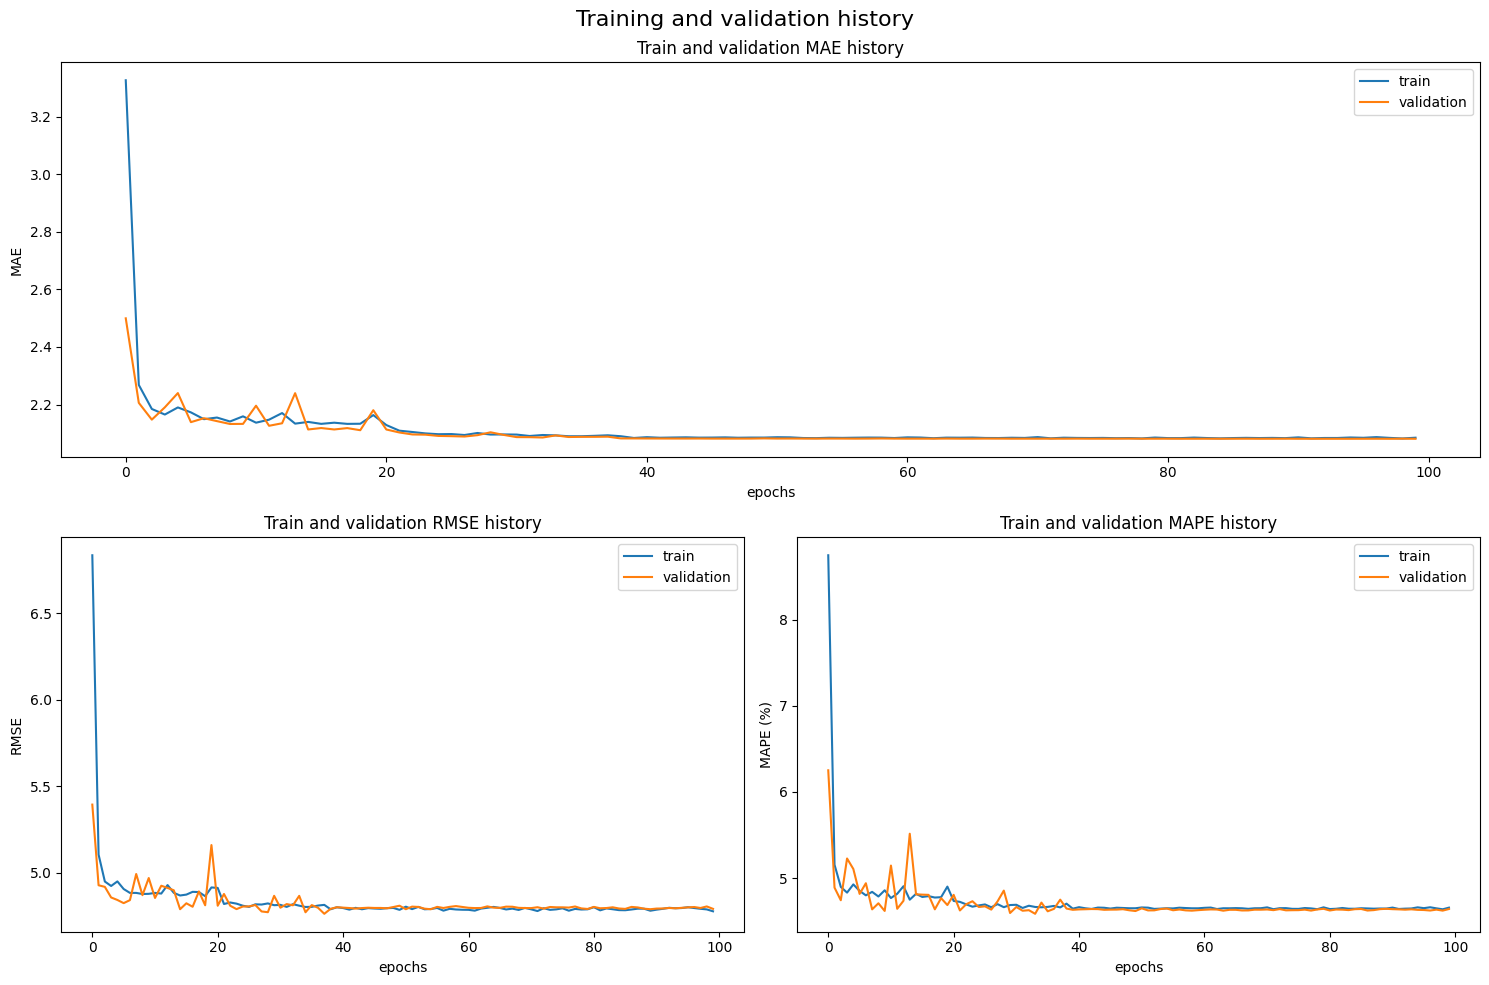

In [42]:
plot_training_history(history)

In [43]:
test_mae_15_min, test_rmse_15_min, test_mape_15_min = validate(
    model, test_dataloader, scaler,
    DEVICE, 3)
print('Results on the test set considering the next 15 minutes:',
      f'MAE {test_mae_15_min:.3f} - RMSE {test_rmse_15_min:.3f}',
      f'- MAPE {test_mape_15_min * 100.:.3f}')

test_mae_30_min, test_rmse_30_min, test_mape_30_min = validate(
    model, test_dataloader, scaler,
    DEVICE, 6)
print('Results on the test set considering the next 30 minutes:',
      f'MAE {test_mae_30_min:.3f} - RMSE {test_rmse_30_min:.3f}',
      f'- MAPE {test_mape_30_min * 100.:.3f}')

test_mae_60_min, test_rmse_60_min, test_mape_60_min = validate(
    model, test_dataloader, scaler,
    DEVICE)
print('Results on the test set considering the next 60 minutes:',
      f'MAE {test_mae_60_min:.3f} - RMSE {test_rmse_60_min:.3f}',
      f'- MAPE {test_mape_60_min * 100.:.3f}')

Results on the test set considering the next 15 minutes: MAE 1.254 - RMSE 2.540 - MAPE 2.468
Results on the test set considering the next 30 minutes: MAE 1.578 - RMSE 3.460 - MAPE 3.242
Results on the test set considering the next 60 minutes: MAE 2.081 - RMSE 4.792 - MAPE 4.641


In [45]:
from src.spatial_temporal_gnn.predictor import get_ground_truth_and_predictions

y_true, y_pred = get_ground_truth_and_predictions(
    model, test_dataloader, DEVICE, scaler, use_standardized_scale=False)

In [46]:
import matplotlib.pyplot as plt

from typing import List

def plot_results_comparison(y_true: np.ndarray, y_pred: np.ndarray,
                            feature_names: List[str]) -> None:
    plt.figure(figsize=(15, 10))
    assert len(feature_names) == y_pred.shape[-1] == y_true.shape[-1], \
        'The feature names length must be the same as the one of the' + \
        'features of the ground truth instances and the predictions'
    
    for i, l in enumerate(feature_names):
        plt.subplot(2, 2, i + 1)
    
        plt.title(f'Comparison of the results for feature {l}')
        
        random_instances = sorted(np.random.choice(range(y_true.shape[0]), 200, replace=False))
        random_nodes = sorted(np.random.choice(range(y_true.shape[2]), 3, replace=False))
        
        y_true_raveled = y_true[random_instances, :][:, :, random_nodes, i].ravel()
        y_pred_reveled = y_pred[random_instances, :][:, :, random_nodes, i].ravel()
        
        filtered = y_true_raveled > 0
        y_true_raveled = y_true_raveled[filtered]
        y_pred_reveled = y_pred_reveled[filtered]

        plt.plot(y_true_raveled, label='ground truth')
        plt.plot(y_pred_reveled, label='predictions')

        plt.xlabel('instance')
        plt.ylabel(l)
        
        plt.legend()
    
    plt.suptitle('Result comparison between the ground truth and the predictions', size=16)
    
    plt.tight_layout()
    plt.show()

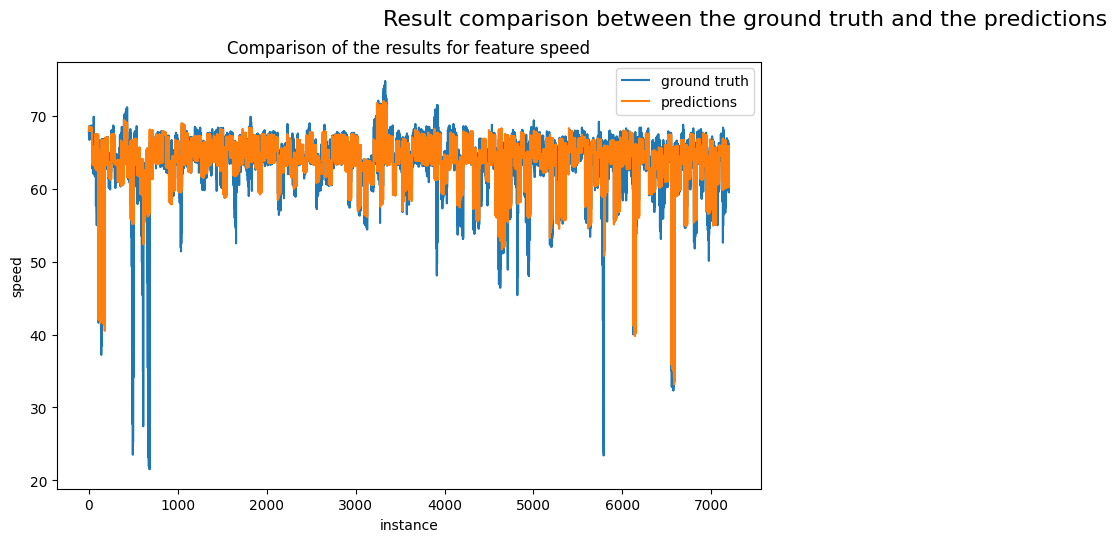

In [47]:
plot_results_comparison(y_true, y_pred, ['speed'])

In [48]:
import matplotlib.pyplot as plt

from typing import List

def plot_results_fitness(y_true: np.ndarray, y_pred: np.ndarray,
                         feature_names: List[str]) -> None:
    plt.figure(figsize=(15, 10))
    assert len(feature_names) == y_pred.shape[-1] == y_true.shape[-1], \
        'The feature names length must be the same as the one of the' + \
        'features of the ground truth instances and the predictions'
    
    for i, l in enumerate(feature_names):
        plt.subplot(2, 2, i + 1)
    
        plt.title(f'Comparison of the fitness results for feature {l}')

        random_instances = sorted(np.random.choice(range(y_true.shape[0]), 100, replace=False))
        random_nodes = sorted(np.random.choice(range(y_true.shape[2]), 50, replace=False))
        
        y_true_raveled = y_true[random_instances, :][:, :, random_nodes, i].ravel()
        y_pred_reveled = y_pred[random_instances, :][:, :, random_nodes, i].ravel()
        
        filtered = y_true_raveled > 0
        y_true_raveled = y_true_raveled[filtered]
        y_pred_reveled = y_pred_reveled[filtered]
    
        plt.scatter(y_true_raveled, y_pred_reveled)
        
        plt.axline((1., 1.), slope=1, color='r', linestyle='--')

        plt.xlabel('ground truth')
        plt.ylabel('prediction')
        
        #plt.legend()
    
    plt.suptitle('Result fitness comparison between the ground truth and the predictions', size=16)
    
    plt.tight_layout()
    plt.show()

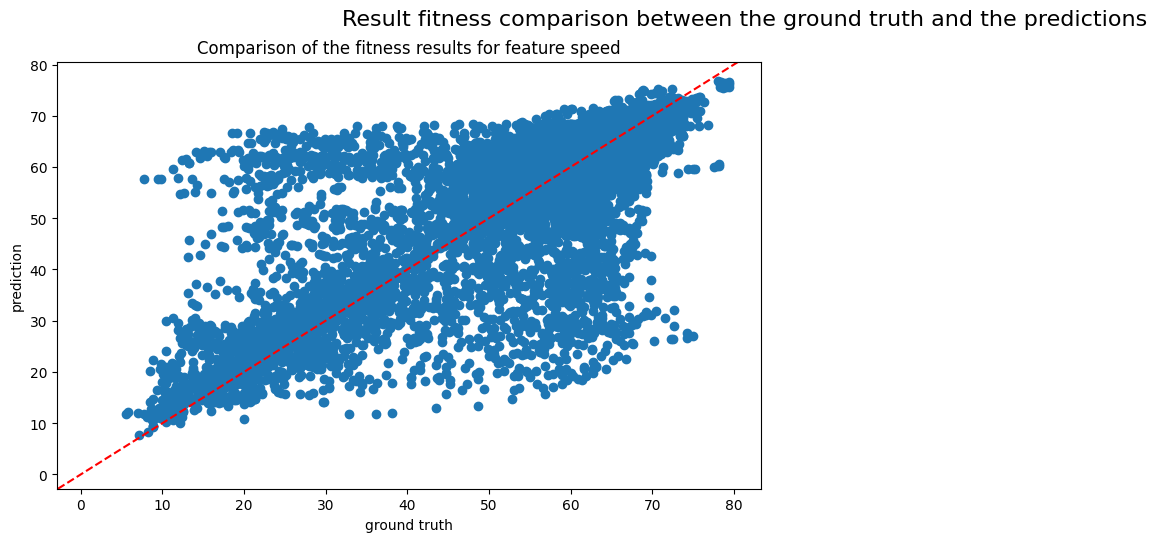

In [49]:
plot_results_fitness(y_true, y_pred, ['speed'])

In [50]:
with torch.no_grad():
    dl = iter(test_dataloader)
    next(dl)
    x, y = next(dl)
    x = x.float().to(DEVICE)
    y = y.float().to(DEVICE)
    x = scaler.scale(x)
    y_p = model(x)
    
    #res = standard_scaler.inverse_transform(y_p[:,:,:,0].cpu().numpy())
    y_p = scaler.un_scale(y_p)
        
    for i in range(y_p.shape[0]):
        for j in range(y_p.shape[1]):
            for k in (range(y_p.shape[2])):
                    print(list(y_p[i][j][k].cpu().numpy()), list(y[i][j][k].cpu().numpy()))
    
    

[61.465694] [61.1]
[64.52878] [64.1]
[60.15415] [59.3]
[60.14489] [60.8]
[35.43875] [33.9]
[63.956974] [64.5]
[44.88886] [47.5]
[64.48864] [65.3]
[65.71556] [66.0]
[62.27468] [62.6]
[64.64343] [63.7]
[65.83507] [66.8]
[64.182686] [63.5]
[64.393234] [64.7]
[63.525112] [64.8]
[66.568] [66.9]
[67.67186] [67.6]
[56.24756] [56.2]
[65.2007] [64.6]
[29.799587] [27.3]
[55.78386] [56.4]
[40.557476] [47.2]
[65.61011] [66.7]
[37.046455] [39.3]
[70.77584] [68.6]
[61.114075] [60.0]
[55.58857] [59.7]
[64.16083] [66.1]
[63.07707] [64.9]
[61.00273] [62.8]
[67.13217] [67.1]
[69.05133] [69.1]
[67.21816] [66.3]
[66.9675] [67.7]
[59.944965] [61.9]
[59.145348] [59.1]
[35.126762] [37.6]
[64.52476] [65.5]
[59.329903] [60.2]
[64.763016] [64.5]
[57.88491] [57.4]
[63.68753] [64.2]
[58.21365] [59.3]
[55.999485] [57.1]
[65.65473] [65.7]
[65.32778] [65.0]
[66.543846] [66.0]
[65.64249] [65.3]
[64.91532] [65.9]
[62.583946] [63.2]
[65.11164] [65.0]
[67.1678] [65.0]
[41.62091] [39.6]
[47.63114] [48.9]
[55.553688] [54.